In [60]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#--------------------------------------------------
#Global parameters
#--------------------------------------------------
ticker = 'SPY' 
start = '2005-01-01'
end = None
trading_days = 250
seed = 42
df_t = 8
price = yf.download(ticker, start, end, auto_adjust = False)['Adj Close'].dropna().squeeze()
#Strategy parameters
sma_window = 200
vol_window = 30
clip_min = 0.0
clip_max = 1.5
#Simulation parameters
horizon_year = 10
n_steps = horizon_year*trading_days
n_paths = 10000
#Fixed GARCH parameters (shape of volatility dynamics)
alpha, beta = 0.05, 0.90


[*********************100%***********************]  1 of 1 completed


In [61]:
#--------------------------------------------------
#1)Data helpers
#--------------------------------------------------

#Daily simple return
def simple_returns(price):
    r = price.pct_change().dropna()
    r.name = 'returns'
    return r
#Convert returns into cumulative wealth
def wealth_from_returns(returns):
    w = (1 + returns).cumprod()
    w.name = 'wealth'
    return w


In [144]:
#Strategy: Trend + Volatility scaling
def trend_vol_strategy(price, sma_window, vol_window, clip_min, clip_max):
    returns =  simple_returns(price)
    vol = returns.rolling(vol_window).std()
    vol_ref = vol.median()
    indicator_vol = (vol_ref/vol).clip(clip_min, clip_max)
    sma = price.rolling(sma_window).mean()
    indicator_sma = (price/sma).clip(clip_min,clip_max)

    weights = (indicator_vol*indicator_sma).shift(1).dropna()
    weights = weights.reindex(returns.index).fillna(0)
    strat_returns = weights * returns
    wealth = wealth_from_returns(strat_returns)
    return strat_returns, wealth

strat_returns = trend_vol_strategy(price, sma_window = 200, vol_window = 30, clip_min = 0, clip_max = 1)[0]
strat_returns = strat_returns[strat_returns!=0]

#Strategy: Buy & Hold 
def buy_and_hold(price):
    returns = simple_returns(price)
    wealth = wealth_from_returns(returns)
    return wealth

In [134]:
#==================================================
#Monte Carlo return generators (Normal and  T, i.i.d. returns) 
#==================================================
bh_mu = simple_returns(price).mean()
bh_sigma = simple_returns(price).std()
bh_sigma2 = simple_returns(price).var()

tv_mu = strat_returns.mean()
tv_sigma = strat_returns.std()
tv_sigma2 = strat_returns.var()


def mc_normal(mu, sigma, n_steps, n_paths, seed):
    '''i.i.d. normal returns'''
    np.random.seed(seed)
    normal_simulation = np.random.normal(mu, sigma, (n_steps, n_paths))
    normal_cumulated_simulation = (1+normal_simulation).cumprod(axis = 0)
    return normal_cumulated_simulation
bh_ncs = mc_normal(bh_mu, bh_sigma, n_steps, n_paths, seed)
tv_ncs = mc_normal(tv_mu, tv_sigma, n_steps, n_paths, seed+1)

def mc_t(mu, sigma, df_t, n_steps, n_paths, seed):
    '''i.i.d. Student-t returns with fat tails'''
    np.random.seed(seed)
    #generate standardized Student-t innovations
    t_simulation = np.random.standard_t(df_t, (n_steps, n_paths))
    z = t_simulation/np.sqrt(df_t/(df_t-2))
    t_scaled_simulation = mu + sigma*z
    t_cumuled_simulation = (1+t_scaled_simulation).cumprod(axis = 0)
    return t_cumuled_simulation
bh_tcs = mc_t(bh_mu, bh_sigma, df_t, n_steps, n_paths, seed)
tv_tcs = mc_t(tv_mu, tv_sigma, df_t, n_steps, n_paths, seed+1)

#Extract terminal wealth from simulated paths
def final_value(cumulated_simulation):
    return cumulated_simulation[-1,:]


In [141]:
#==================================================
#GARCH with Normal and Student-T noises    
#==================================================

#GARCH(1,1) model with Gaussian shoks
def garch_normal_noise(alpha, beta, mu, sigma2, n_steps, n_paths, seed):
    np.random.seed(seed)
    omega = sigma2*(1-alpha-beta)
    r = np.zeros((n_steps,n_paths))
    s2 = np.zeros((n_steps,n_paths))
    #initialize variance 
    s2[0,:] = sigma2
    #generate standardized shoks
    eps = np.random.normal(0,1,(n_steps,n_paths))
    #initialized first return
    r[0,:] = mu + np.sqrt(s2[0])*eps[0]
    #GARCH recurtion
    for i in range(1,n_steps):
        s2[i] = omega + alpha*(r[i-1]-mu)**2+beta*s2[i-1]
        r[i] = mu + np.sqrt(s2[i])*eps[i]
    garch_normal_cumulated_simulation = (1+r).cumprod(axis = 0)
    return garch_normal_cumulated_simulation
bh_gncs = garch_normal_noise(alpha, beta, bh_mu, bh_sigma2, n_steps, n_paths, seed)
tv_gncs = garch_normal_noise(alpha, beta, tv_mu, tv_sigma2, n_steps, n_paths, seed+1)

def garch_t_noise(alpha, beta, mu, sigma2, df_t, n_steps, n_paths, seed):
    np.random.seed(seed)
    omega = sigma2*(1-alpha-beta)
    r = np.zeros((n_steps,n_paths))
    s2 = np.zeros((n_steps,n_paths))
    s2[0,:] = sigma2
    #Student-t innovations standardized to unit variance
    eps_t = np.random.standard_t(df_t, (n_steps, n_paths))
    eps_t_standard = eps_t/np.sqrt(df_t/(df_t-2))
    r[0,:] = mu + np.sqrt(s2[0])*eps_t_standard[0]
    for i in range(1,n_steps):
        s2[i] = omega + alpha*(r[i-1]-mu)**2+beta*s2[i-1]
        r[i] = mu + np.sqrt(s2[i])*eps_t_standard[i]
    garch_t_cumulated_simulation = (1+r).cumprod(axis = 0)
    return garch_t_cumulated_simulation
bh_gtcs = garch_t_noise(alpha, beta, bh_mu, bh_sigma2, df_t, n_steps, n_paths, seed)
tv_gtcs = garch_t_noise(alpha, beta, tv_mu, tv_sigma2, df_t, n_steps, n_paths, seed+1)

In [178]:
#==================================================
#GARCH with Normal and Student-T noises    
#==================================================

#Risk and distributional metrics on terminal wealth
def metrics(final_value):
    prob_loss = (final_value<1).mean()
    p1 = np.percentile(final_value,1)
    p5 = np.percentile(final_value,5)
    p10 = np.percentile(final_value,10)
    p50 = np.percentile(final_value,50)
    p90 = np.percentile(final_value,90)
    p95 = np.percentile(final_value,95)
    p99 = np.percentile(final_value,99)
    conditional_loss = (1-final_value[final_value<1]).mean()
    return (prob_loss, p1, p5,p10, p50,p90,p95,p99,conditional_loss)


In [179]:
df = pd.DataFrame({
    'bh_Normal-Montecarlo' : metrics(final_value(bh_ncs)), 
    'bh_Student-t-Montecarlo' : metrics(final_value(bh_tcs)),
    'bh_GARCH Normal' : metrics(final_value(bh_gncs)),
    'bh_GARCH-t' : metrics(final_value(bh_gtcs))}, index = ['prob_loss', 'p1', 'p5','p10', 'p50', 'p90','p95', 'p99', 'conditional_loss'])
df.round(4)    


,bh_Normal-Montecarlo,bh_Student-t-Montecarlo,bh_GARCH Normal,bh_GARCH-t
prob_loss,0.0484,0.0520,0.0480,0.0506
p1,0.6506,0.6446,0.6515,0.6369
p5,1.0114,0.9875,1.0158,0.9974
p10,1.2515,1.2384,1.2436,1.2281
p50,2.7212,2.7159,2.7209,2.7126
p90,5.8925,5.8349,5.8416,5.8049
p95,7.2560,7.2507,7.2503,7.2156
p99,11.0669,10.7237,11.0609,10.6221
conditional_loss,0.2093,0.2141,0.2106,0.2190


In [180]:
df = pd.DataFrame({
    'tv_Normal-Montecarlo' : metrics(final_value(tv_ncs)), 
    'tv_Student-t-Montecarlo' : metrics(final_value(tv_tcs)),
    'tv_GARCH Normal' : metrics(final_value(tv_gncs)),
    'tv_GARCH-t' : metrics(final_value(tv_gtcs))}, index = ['prob_loss', 'p1', 'p5','p10', 'p50', 'p90','p95', 'p99', 'conditional_loss'])
df.round(4)    

,tv_Normal-Montecarlo,tv_Student-t-Montecarlo,tv_GARCH Normal,tv_GARCH-t
prob_loss,0.0066,0.0079,0.0075,0.0084
p1,1.0368,1.0331,1.0468,1.0247
p5,1.3151,1.3400,1.3127,1.3417
p10,1.5134,1.5321,1.5064,1.5296
p50,2.4523,2.4543,2.4541,2.4599
p90,3.9697,3.9526,3.9725,3.9339
p95,4.5597,4.5075,4.5606,4.5009
p99,5.9081,5.6906,5.9743,5.6891
conditional_loss,0.1084,0.0946,0.0987,0.0989


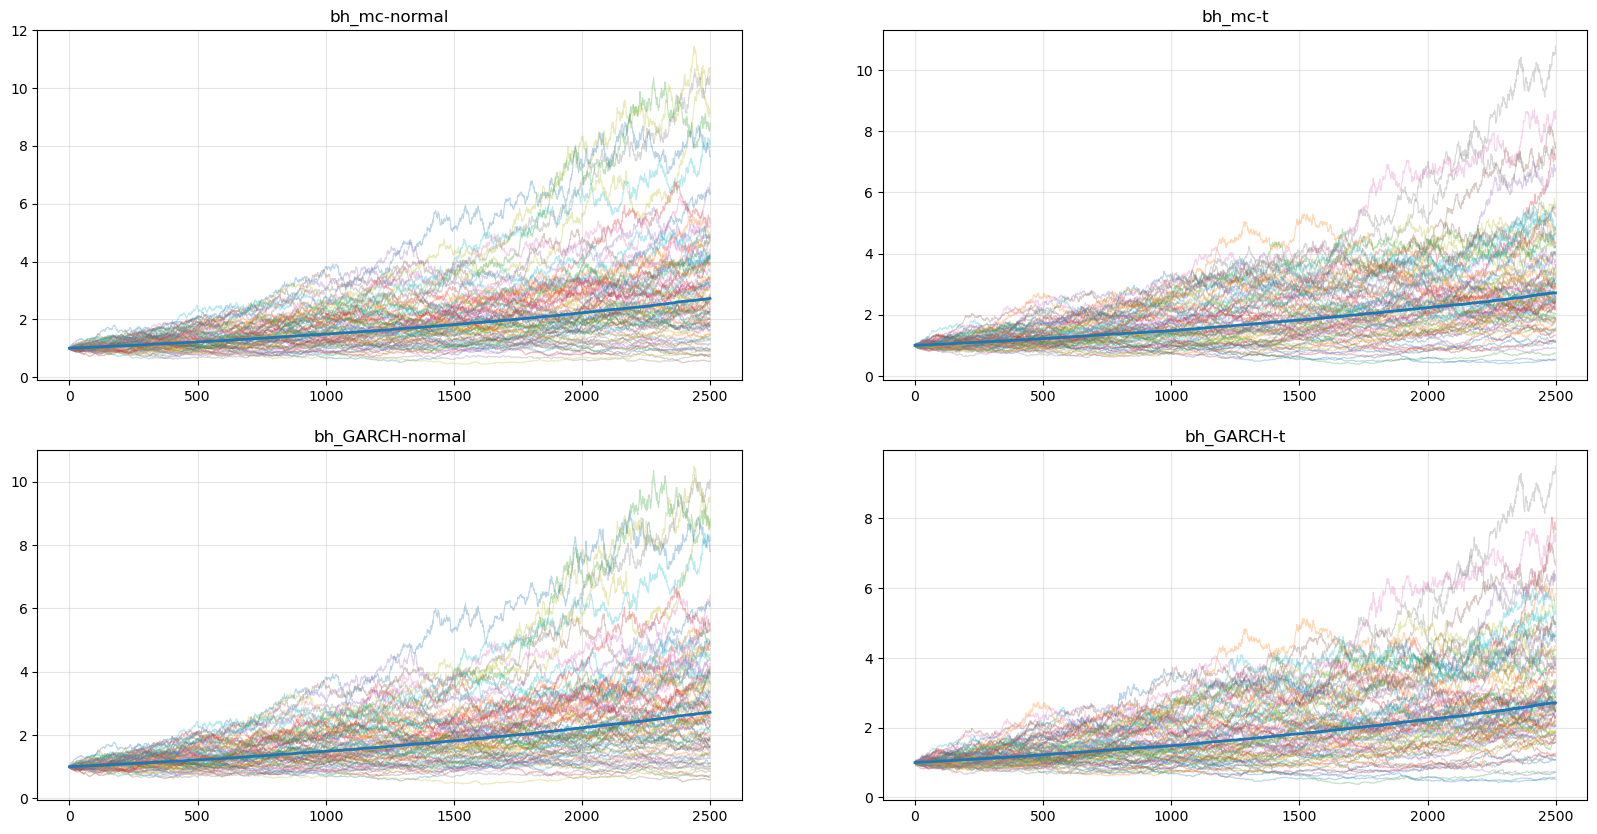

In [181]:
plt.figure(figsize = (20,10))
plots = [
    ('bh_mc-normal', bh_ncs),
    ('bh_mc-t', bh_tcs),
    ('bh_GARCH-normal', bh_gncs),
    ('bh_GARCH-t', bh_gtcs)]
for k, (title, W) in enumerate(plots, 1):
    plt.subplot(2,2,k)
    for i in range(80):
        plt.plot(W[:,i], linewidth = 0.8, alpha=0.3)
    plt.plot(np.median(W, axis=1), linewidth = 2)
    plt.title(title)
    plt.grid(True, alpha = 0.3)
plt.show()

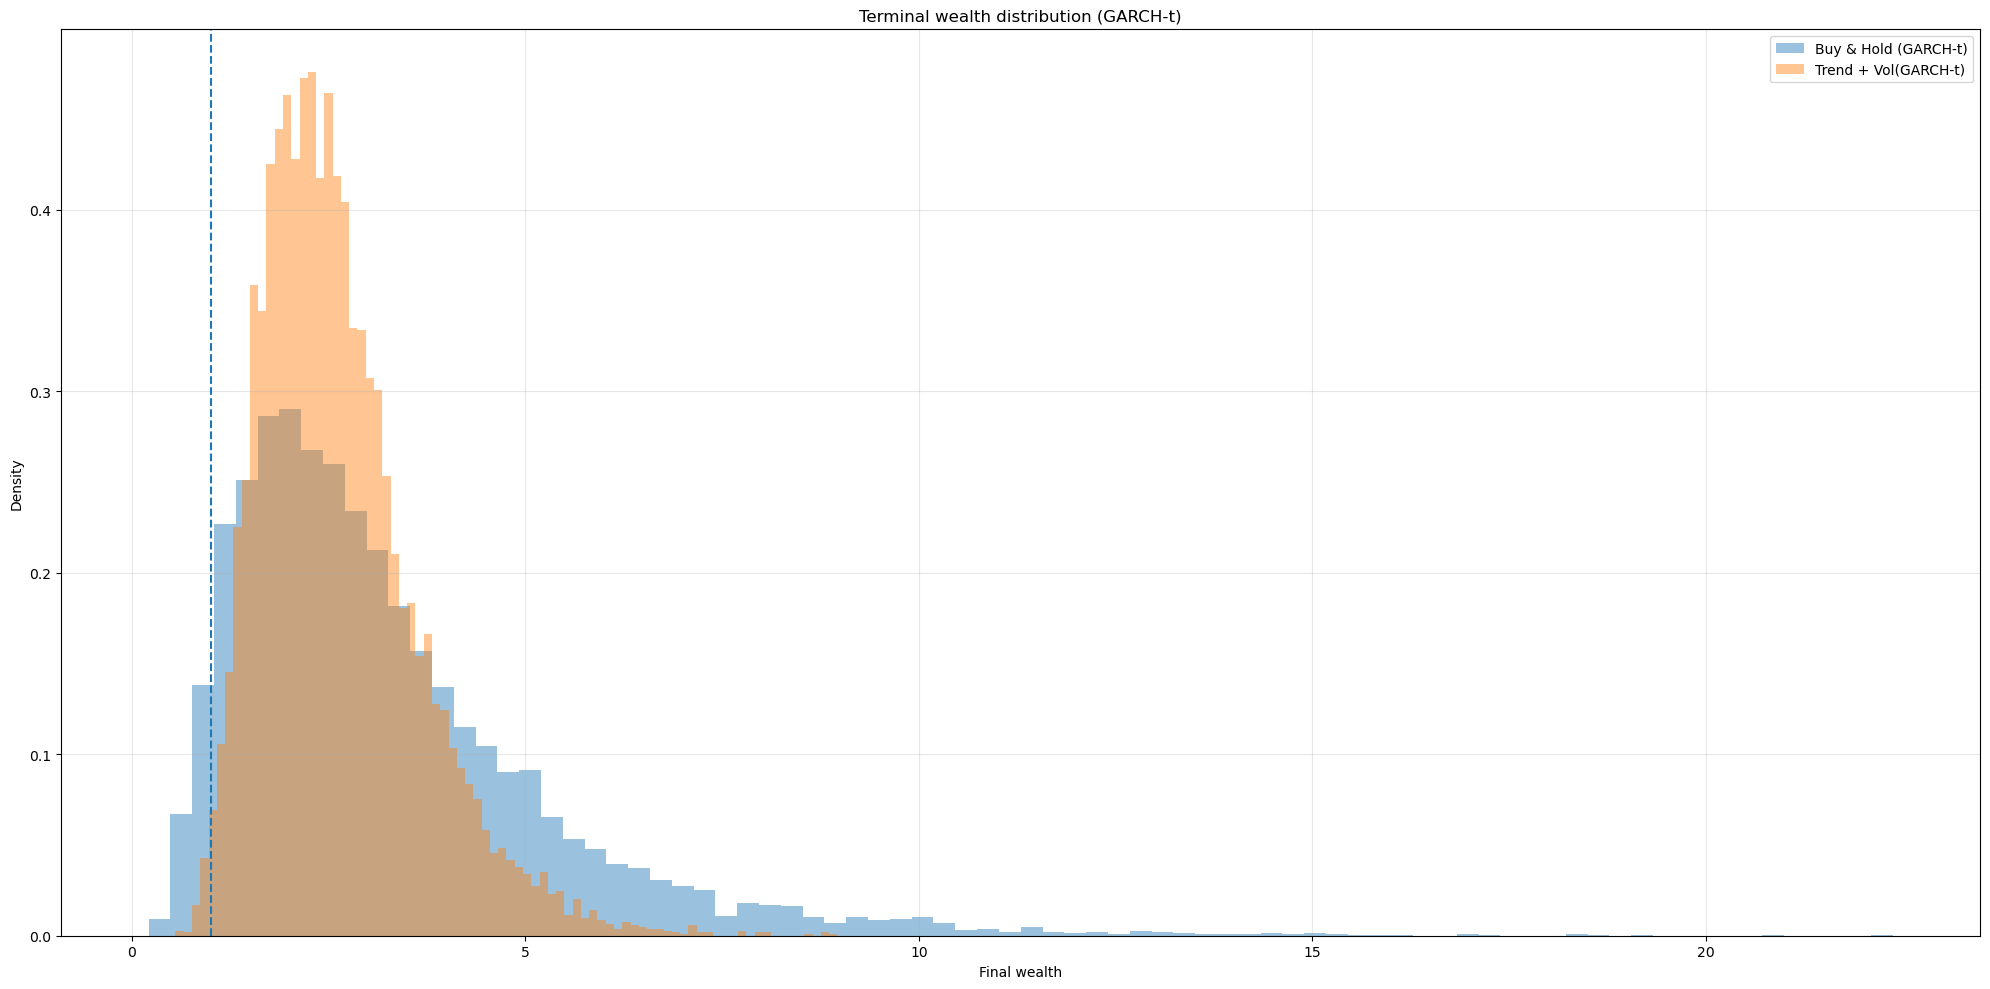

In [182]:
plt.figure(figsize = (20,10))
plt.hist(final_value(bh_gtcs), bins = 80, density = True, alpha = 0.45, label = 'Buy & Hold (GARCH-t)')
plt.hist(final_value(tv_gtcs), bins = 80, density = True, alpha = 0.45, label = 'Trend + Vol(GARCH-t)')
plt.axvline(1.0, linestyle = '--', linewidth = 1.5) #break-even point
plt.title('Terminal wealth distribution (GARCH-t)')
plt.xlabel('Final wealth')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha = 0.3)
plt.tight_layout()
plt.show()

This histogram compares the distribution of terminal wealth under a stress-oriented setting (GARCH-t) for Buy & Hold and the Trend + Volatility strategy. The break-even line at 1 highlights the probability of ending the horizon below the initial capital. The strategy shifts mass away from the left tail (downside protection) at the cost of reducing extreme upside outcomes.

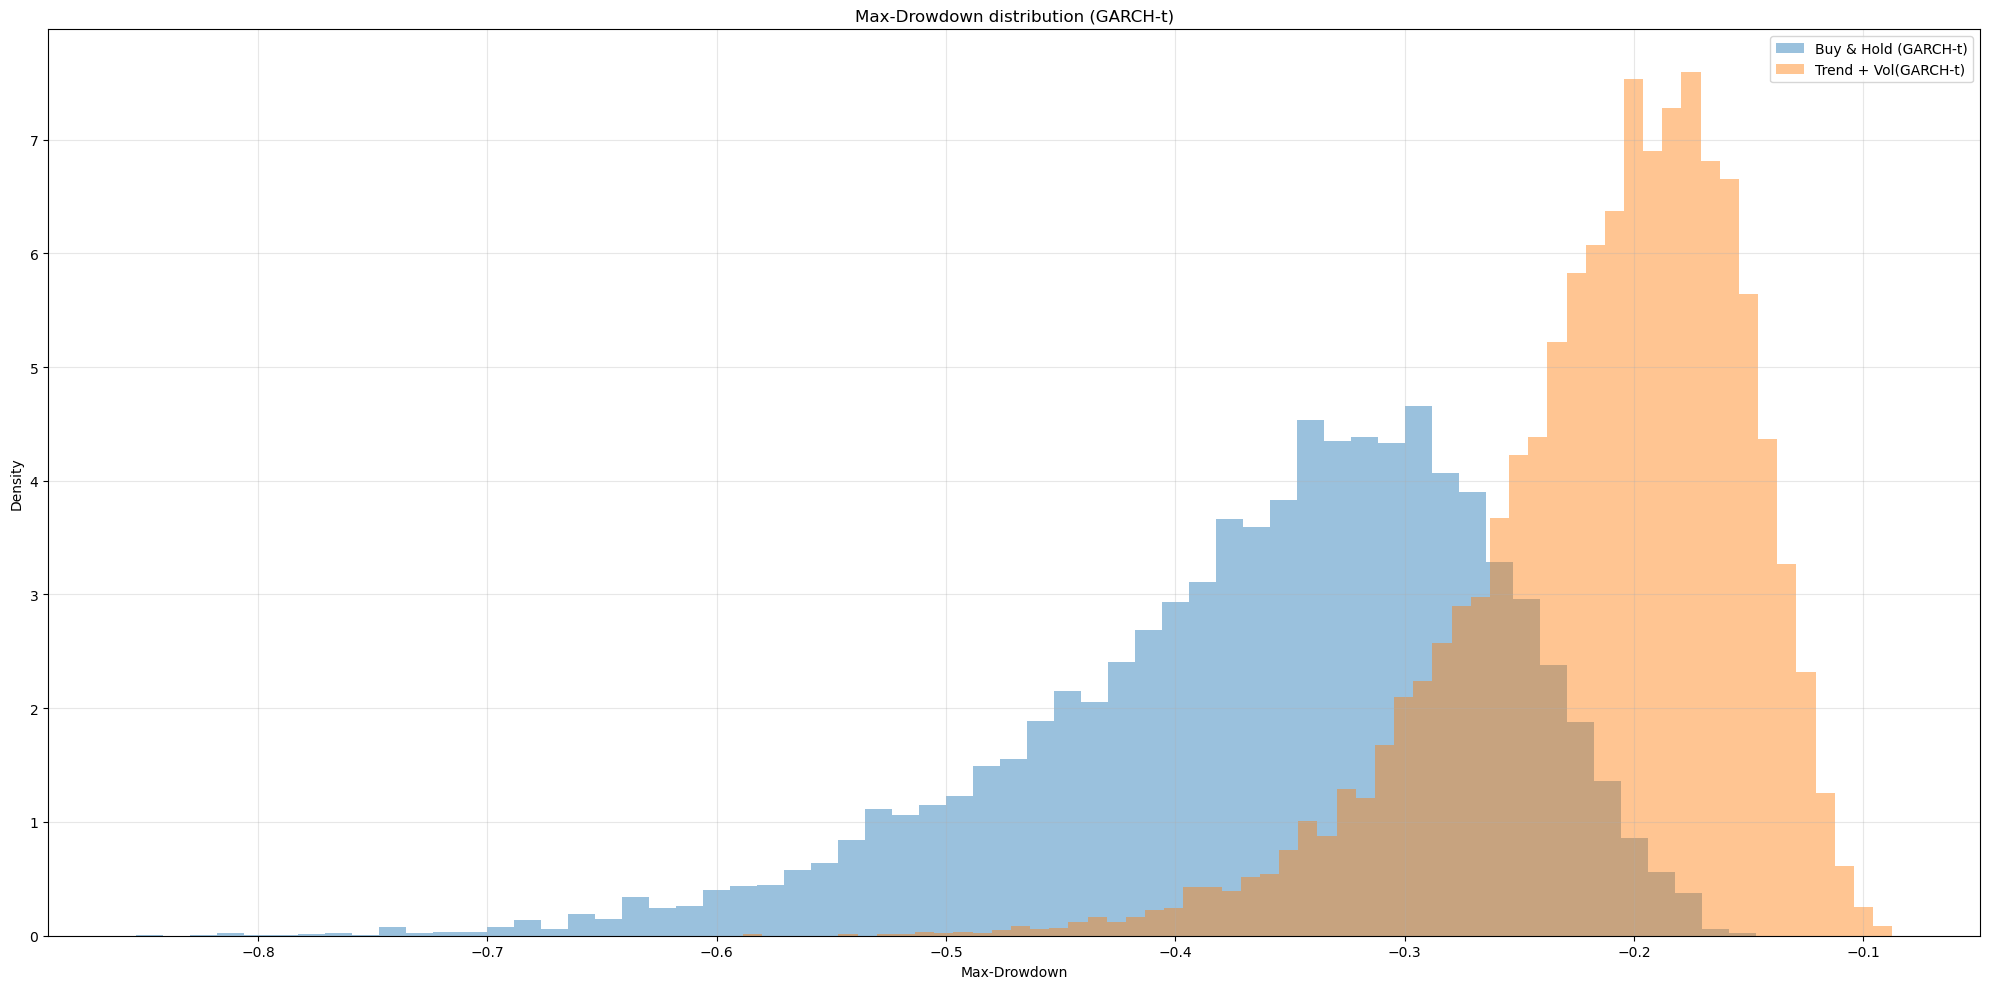

In [183]:
def max_drowdown(W):
    running_max = np.maximum.accumulate(W, axis=0)
    dd = (W/running_max) - 1
    return dd.min(axis = 0)
mdd_bh = max_drowdown(bh_gtcs)
mdd_tv = max_drowdown(tv_gtcs)

plt.figure(figsize = (20,10))
plt.hist(mdd_bh, bins = 60, density = True, alpha = 0.45, label = 'Buy & Hold (GARCH-t)')
plt.hist(mdd_tv, bins = 60, density = True, alpha = 0.45, label = 'Trend + Vol(GARCH-t)')
plt.title('Max-Drowdown distribution (GARCH-t)')
plt.xlabel('Max-Drowdown')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha = 0.3)
plt.tight_layout()
plt.show()

This figure shows the distribution of maximum drawdowns across simulated paths under the GARCH-t model. Compared to Buy & Hold, the Trend + Volatility strategy concentrates outcomes at shallower drawdowns, indicating improved path-level risk control. This highlights that volatility modeling matters especially for path-dependent risk, not only for terminal wealth.